# Welch's periodograms and spectrograms

In [1]:
%pylab inline
from matplotlib import style
style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import pi as PI
from scipy import signal
from scipy.integrate import simps

## Computing the power spectrum


The spectral power computes the power of the signal at a frequency. The spectral amplitude distribution is the series of amplitudes for each component of the oscillation. To plot the power spectrum we need to calculate first the Fourier coefficients to obtain the amplitudes or powers. To do it, the data can be taken into a number of components or segments. To obtain the power spectrum of a signal, we simply square the amplitude of the oscillation. 

When computing the Fourier transforms or any spectra, it is generaly advisable to define the **spectral resolution** or **frequency resolution**. 
It is the spacing between successive frequencies, and it is given by the ratio between the sampling rate and the total number of samples of the signal. Thus, at a fixed sampling 

<BR>
$$
\text{Spectral resolution} = \frac{\text{Sampling Rate}}{\text{Nsamples}}
$$
    
<BR>
The Welch method computes an estimate of the power spectrum by averaging the data into overlapping segments, 
The length of the segment determin the appropiate spectral resolution.
<BR>
    
Other aspects to take into account is the tappering window to be applied, and the degree of overlap between segments.

In [3]:
%ls data

2019-06-06CM_ch25.npy  EEGrestingState.mat  EEG.txt


## A synthetic sine wave 

A 120 seconds **sine** signal sampled at 100 Hz

Nysquist frequency is 50 Hz


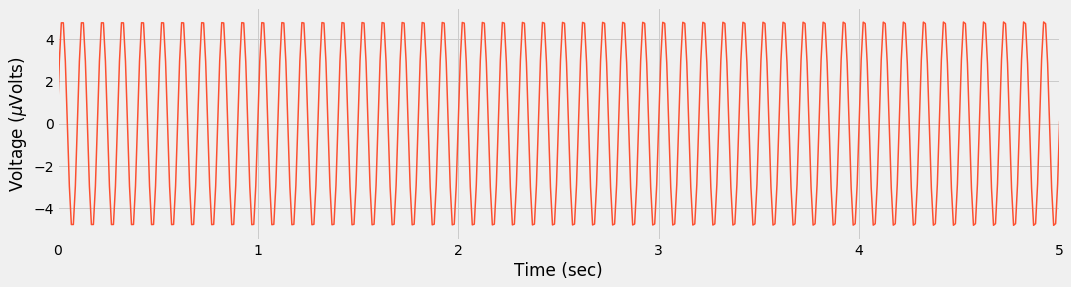

In [4]:
srate = 100
Nyquist = srate/2
print('Nysquist frequency is %d Hz'%Nyquist)
time = np.linspace(0,120,num=120*srate)
mysine = lambda f: np.sin(2*PI*f*time) 

sine = 5*mysine(10)
# Plot only 5 second
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(time, sine, lw = 1.5, color='C1')
plt.xlabel('Time (sec)'), plt.ylabel('Voltage ($\mu$Volts)');
plt.xlim(0,5);

The two normalizations necessary to obtain the amplitudes from the Fourier coefficients are:

    1) Divide the Fourier coefficients by the size of the signal
    2) multipy by two to obtain the amplitude of the negative frequencies
    
In addition, we can set the DC-component to zero.

In [5]:
# Fourier transform
FourierCoeff = np.fft.fft(sine)/sine.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(sine.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%dhz)

Spectral resolution = 0.0083 Hz


For the Welch's periodogram, the spectral resolution is given by the lenght of the segment. If we take a segment that correspond to the sampling rate, then the frequency resolution is 1 Hz. A larger segment (e.g., 4 times the size of the sampling rate) would give a higher frequency resolution (0.25 Hz). 

Welch's periodogram will return the power (amplitude to the square) versus frequency. We can also have the power density. Power density is the power per Hz, and if we take a segment which is four times the sampling rate, then the power will be multiplied by four to return power/Hz. In this case, when we add in Welch's, **scaling=density** and will obtain the power times 4, because our segment has a lenght of four times the sampling rate.

In [6]:
# Perform Welch's periodogram
segment = int( srate*5 ) 
myhann = signal.get_window('hann', segment)

# obtain simply Power (amplitude^2) withouth tappering
myparams = dict(fs = srate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'spectrum', return_onesided=True)
freq, ps = signal.welch(x = sine, **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

#obtain Power density (amplitude^2/Hz) withouth tappering
myparams = dict(fs = srate, nperseg = segment, window = np.ones(segment), 
                noverlap = 0, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = sine, **myparams)# units uV**2/Hz
psd = 2*psd # correct for negative frequencies

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2000 Hz


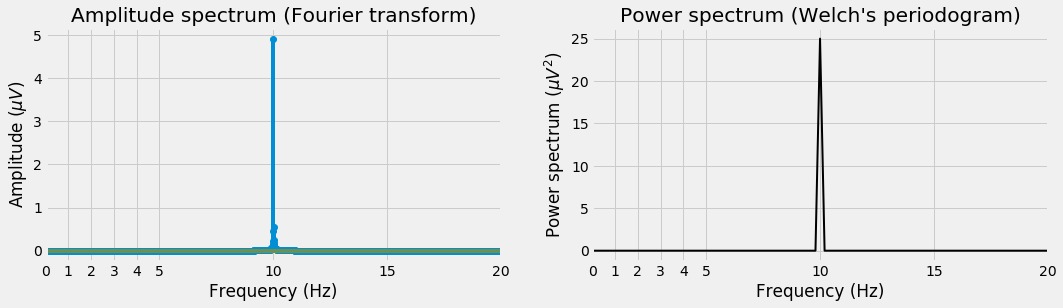

In [7]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(freq, ps, color='k', lw=2) 
ax[1].set_ylabel('Power spectrum ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,20)
    myticks = list(range(6)) + list(range(10, 25,5))
    myax.set_xticks(myticks)

In [8]:
# Sine wave has an amplitude of 2 uV, the power is 4 uV and the power density is 4*5 if we took 
# a segment with size = 4x the sampling rate. 
print('Signal amplitude     = %2.4f uVolts'%amp[int(10/dhz)]) 
print('Signal power         = %2.4f uVolts^2'%ps[int(10/dfreq)])
print('Singal power density = %2.4f uVolts^2/Hz'%psd[int(10/dfreq)])

Signal amplitude     = 4.9179 uVolts
Signal power         = 24.9965 uVolts^2
Singal power density = 124.9824 uVolts^2/Hz


In [9]:
np.sqrt(124.9824/5)

4.999647987608728

In [10]:
# Plot spectrogram
# now we will analyze window lenghts of 500 ms 
segment = int(0.5*srate) # 500 points (0.5 sec, 500 ms)

# we have less frequency resolution here because the signals are smaller
Nsamples = int( np.floor(segment/2) )
hz = np.linspace(0, Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 2.0000 Hz


In [11]:
nsteps = int(np.floor( (sine.size/segment)) )
print(sine.size, nsteps)

12000 240


In [12]:
dt = 1/srate
sine.size*dt

120.0

In [13]:
dt_segment = 1/0.50 # the segment is half the sampling of the signal
nsteps/dt_segment

120.0

In [14]:
# compute manually the Fourier transform
myamp = list()
for i in range(nsteps):
    
    # signal duration 500 ms 
    pstart = i*segment
    data = sine[ pstart : pstart + segment]
    #data = sine[i*step:i*step+segment]
    
    FourierCoeff = np.fft.fft(data)/segment
    DC = [np.abs(FourierCoeff[0])] # DC component
    fft = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = fft[:int(45/dfreq)] # only until 45 Hz
    myamp.append( amp )

hz = hz[:int(45/dfreq)]

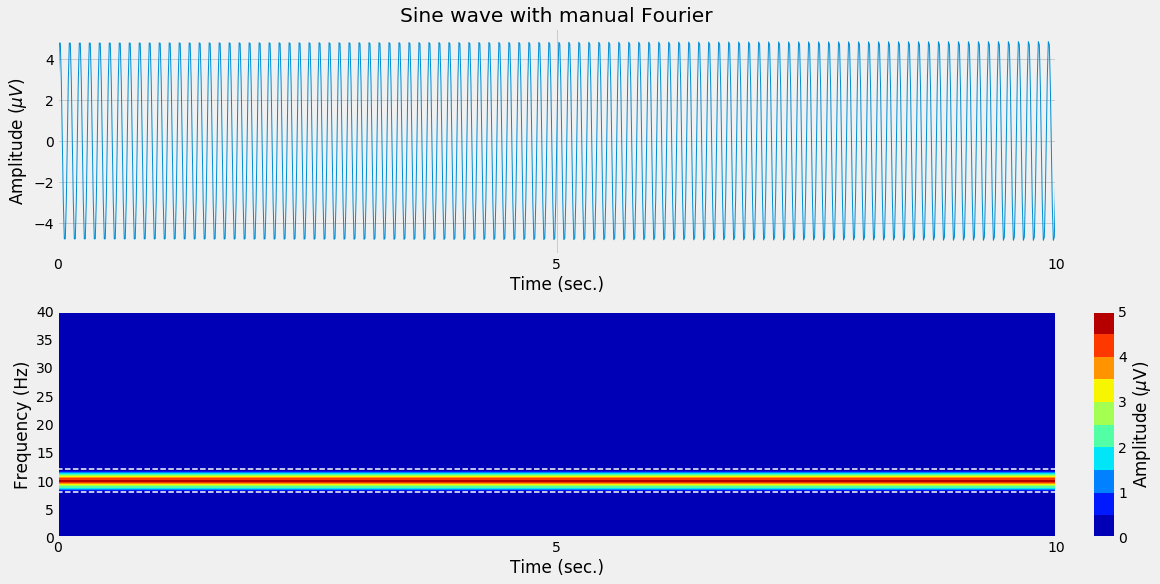

In [15]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

# Plot the recording
ax[0].plot(time, sine, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('Sine wave with manual Fourier')

# spectrum is a ContourSet object
dt_segment= 1/0.5 # one segment is 0.5 seconds

X = np.arange(nsteps)/dt_segment
Y = hz
Z = np.array(myamp).T # shape freq,time
levels = 10
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# adjust the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
#cbar.set_ticks(np.arange(0,5,10))

#A working example (for any value range) with five ticks along the bar is:

#m0=int(np.floor(np.min(myamp)))            # colorbar min value
#m4=int(np.ceil(np.max(myamp)))             # colorbar max value
#m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
#m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
#m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
#cbar.set_ticks([m0,m1,m2,m3,m4])
#cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xticks(np.arange(0, 121, 5))
    myax.set_xlim(0, 10)
    myax.set_xlabel('Time (sec.)')

In [16]:
# With scipy 

myparams = dict(nperseg = segment, noverlap = 0, return_onesided=True, scaling='density')
freq, nseg, Sxx = signal.spectrogram(x = sine, fs=srate, **myparams)

Sxx = 2*Sxx
print('Frequency resolution = %2.4f Hz'%freq[1])

Frequency resolution = 2.0000 Hz


In [17]:
Sxx.shape

(26, 240)

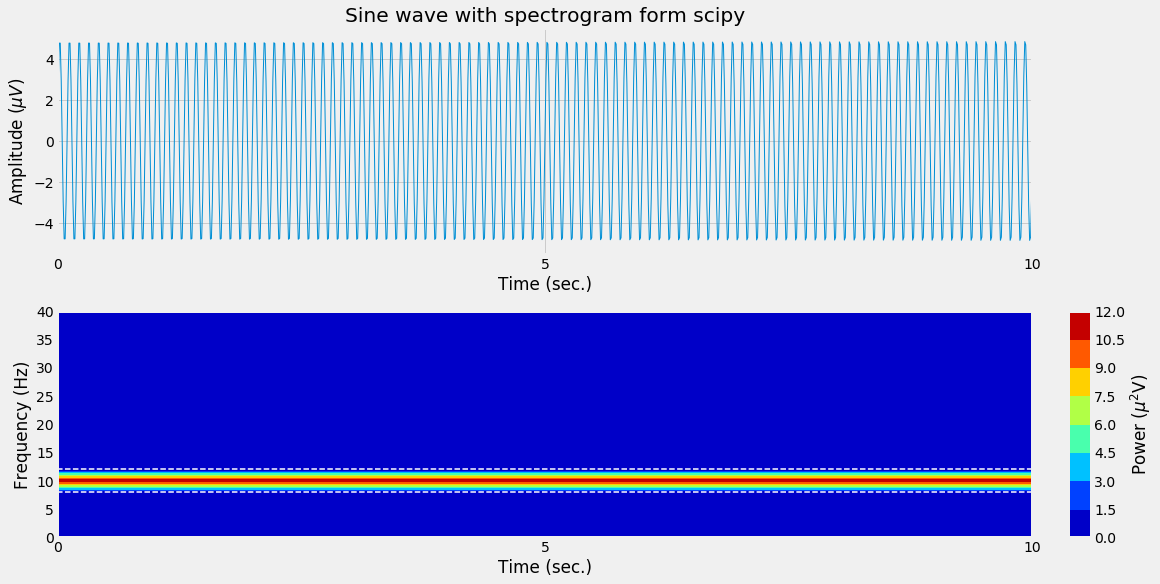

In [18]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, sine, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('Sine wave with spectrogram form scipy')

# spectrum is a ContourSet object
dt = sine.size/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = freq
Z = Sxx
levels = 10
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Power ($\mu^2$V)', rotation=90)
#cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

#m0=int(np.floor(np.min(Sxx)))            # colorbar min value
#m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
#m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
#m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
#m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
#cbar.set_ticks([m0,m1,m2,m3,m4])
#cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xticks(np.arange(0, 121, 5))
    myax.set_xlim(0, 10)
    myax.set_xlabel('Time (sec.)')

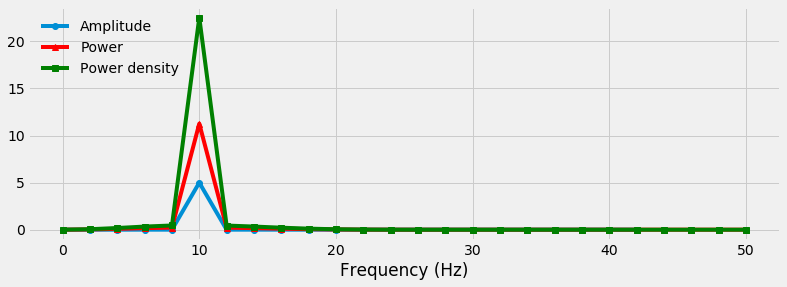

In [19]:
# Plot first spectrum
plt.figure( figsize=(12,4))

mypower = Sxx[:,0]
plt.plot(hz,myamp[0], 'o-', color='C0', label='Amplitude')
plt.plot(freq, mypower, '^-', color='red', label='Power')
plt.plot(freq, mypower/0.5, 's-', color='green', label = 'Power density')
plt.xlabel("Frequency (Hz)")
plt.legend(frameon = False, loc=2);

## Example of EGG with delta band

Nysquid frequency is 50 Hz


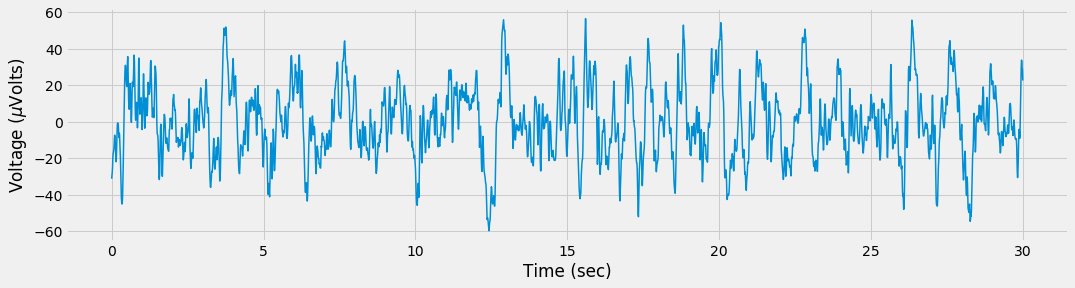

In [20]:
eeg = np.loadtxt('data/EEG.txt')
sr = 100 # samples per second
dt = 1/sr
time = np.arange(eeg.size)*dt

Nysquid = sr/2
print('Nysquid frequency is %d Hz'%Nysquid)
fig, ax = plt.subplots(figsize=(16,4))
plt.plot(time, eeg, lw = 1.5)
plt.xlabel('Time (sec)'), plt.ylabel('Voltage ($\mu$Volts)');

In [21]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nsamples = int( math.floor(eeg.size/2) )
hz = np.linspace(0, sr/2., num = Nsamples + 1 )
print('Spectral resolution = %2.4f Hz'%hz[1])

Spectral resolution = 0.0333 Hz


In [22]:
# Perform Welch's periodogram with hann window and 50% overlap
segment = int( 5*sr ) 
myhann = signal.get_window('hann', segment)


# obtain simply Power (uV^2) with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, 
                noverlap = segment/2, scaling = 'spectrum', return_onesided=True)

freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps # correct for negative frequencies

# obtain Power density (uV^2/Hz) with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, 
                 noverlap = segment/2, scaling = 'density', return_onesided=True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2000 Hz


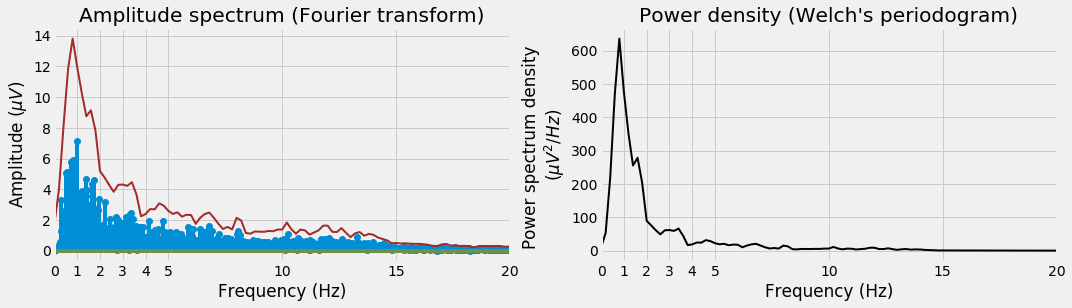

In [23]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].stem(hz,amp[:len(hz)], use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps), color='brown', lw = 2)
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power density (Welch's periodogram)")
ax[1].plot(freq, psd, color='k', lw=2)

ax[1].set_ylabel('Power spectrum density \n($\mu V^2/Hz$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,20)
    myticks = list(range(6)) + list(range(10, 25,5))
    myax.set_xticks(myticks)

In [24]:
# compute the signal at 1 Hz
print('Signal amplitude @1Hz     = %2.4f uVolts'%amp[int(1/dhz)]) 
print('Signal power @1Hz         = %2.4f uVolts^2'%ps[int(1/dfreq)])
print('Singal power density @1Hz = %2.4f uVolts^2/Hz'%psd[int(1/dfreq)])

Signal amplitude @1Hz     = 0.8944 uVolts
Signal power @1Hz         = 142.7474 uVolts^2
Singal power density @1Hz = 475.8246 uVolts^2/Hz


In [25]:
np.sqrt(475.8246/5)

9.755250893749478

The relative band (absolute power divided by the total power of the spectrum)
can be calculated, irrespective of if power of power densities are given in 
the Welch's spectrum.

In [26]:
# compute delta-band only for power densities!!!
idx_delta = np.logical_and(freq >= 0.4, freq <=4)
delta_power = simps(psd[idx_delta], dx = dfreq)
total_power = simps(psd, dx = dfreq)

print('Absolute delta power: %.3f uV^2' % delta_power)
print('Relative delta power: %.3f ' % (delta_power/total_power))

Absolute delta power: 673.447 uV^2
Relative delta power: 0.826 


In [27]:
# With scipy 
segment = int(sr)
myparams = dict(nperseg = segment, noverlap = 0, return_onesided=True, scaling='spectrum')
freq, nseg, Sxx = signal.spectrogram(x = eeg, fs=srate, **myparams)

Sxx = 2*Sxx
print('Frequency resolution = %2.4f Hz'%freq[1])

Frequency resolution = 1.0000 Hz


In [28]:
len(freq), len(nseg), len(eeg)

(51, 30, 3000)

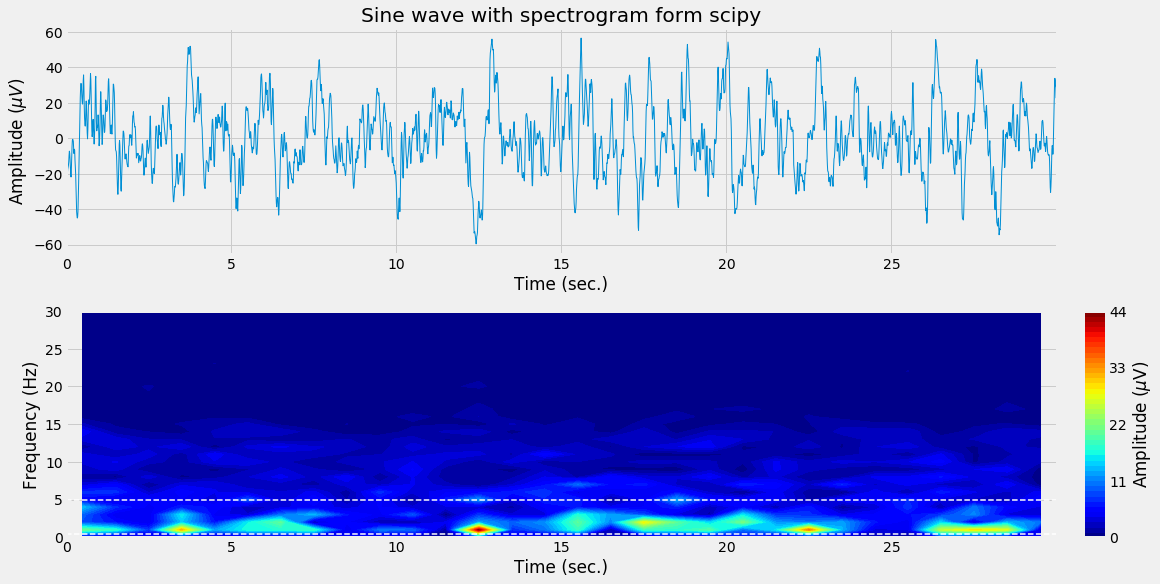

In [29]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('Sine wave with spectrogram form scipy')

myamp = np.sqrt(Sxx)
# spectrum is a ContourSet object
dt_seg = 1 # 120 seconds in number of steps

Z = myamp
Y = freq
X = 0.5+np.arange(len(nseg))
levels = 50
mycontour = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(mycontour)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
#cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(myamp)))            # colorbar min value
m4=int(np.ceil(np.max(myamp)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 0.5, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 5, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylim([0,30])
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xticks(np.arange(0, 30, 5))
    myax.set_xlim(0, 30)
    myax.set_xlabel('Time (sec.)')